In [1]:
import warnings
warnings.filterwarnings("ignore")

import io
import os
import os.path
import re
import spacy
import time
import pickle

import numpy as np
import pandas as pd
from pprint import pprint

import gensim
from gensim.models import Phrases, LdaModel, CoherenceModel
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from gensim.test.utils import datapath

import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
os.environ.update({'MALLET_HOME':r'C:/mallet-2.0.8/'})
mallet_path = 'C:\mallet-2.0.8\bin\mallet'
pd.options.display.max_columns = 100

In [2]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def compute_coherence_values(id2word, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    chunksize = 2000
    passes = 20
    iterations = 400
    eval_every = None  # Don't evaluate model perplexity, takes too much time.
    for num_topics in range(start, limit, step):
        ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word, random_seed=50)
        model_list.append(ldamallet)
        coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model_ldamallet.get_coherence())

    return model_list, coherence_values

def loop_compute_coherence_values(id2word, corpus, texts, limit, mallet_path, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word, random_seed=50)
        model_list.append(ldamallet)
        coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model_ldamallet.get_coherence())
        print(num_topics)
    return model_list, coherence_values

# Load and process News Tweets

In [3]:
#
news_accounts = pd.read_csv('./../data/raw/news_accounts.csv')
news_tweets = pd.read_csv('./../data/raw/news_tweets.csv')
news_tweets = news_tweets.merge(news_accounts[['author_id', 'country']])

#
news_tweets = news_tweets.sort_values('created_at')
news_tweets = news_tweets.drop_duplicates('conversation_id', keep='first')
news_tweets = news_tweets.drop_duplicates('text', keep='first')
news_tweets = news_tweets[news_tweets.lang=='en']
print('Number of valid news tweets:', news_tweets.shape[0])

# Generate content file
news_tweets = news_tweets.reset_index(drop=True)
data = list(news_tweets.text)
print("Just collected", len(data), "tweets.")

Number of valid news tweets: 1632183
Just collected 1632183 tweets.


In [ ]:
# # Load lookup tables
# media_list = pd.read_csv('./../data/external/MediaList.csv', sep=";")
# news_accounts = pd.read_parquet('./../data/raw/news_accounts.parquet')
# emotions = ['anger', 'sadness', 'optimism', 'joy']

# # Process lookup tables
# news_accounts = news_accounts.merge(media_list)
# news_accounts['userId'] = news_accounts.userId.astype('float64')

# # Load news tweets
# news_tweets = pd.read_parquet('./../data/processed/consolidated/consolidated_news_tweets.parquet')

# # Include country information and filter valid news accountsw
# news_tweets = news_tweets.merge(news_accounts[['userId','country']])
# news_tweets = news_tweets.sort_values('date').drop_duplicates('conversationId', keep='first')
# news_tweets = news_tweets[news_tweets.lang=='en']
# print('Number of valid news tweets:', news_tweets.shape[0])

# # Generate content file
# news_tweets = news_tweets.reset_index(drop=True)
# data = list(news_tweets.content)
# print("Just collected", len(data), "tweets.")
# del media_list, news_accounts

In [30]:
# Clean data
start = time.time()
nlp = spacy.load("en_core_web_sm")
docs = []
for doc in nlp.pipe(data, disable=["tok2vec", "tagger", "parser", "attribute_ruler"]):
    docs.append([
        re.sub(r'[^\w\s]|[0-9]|[_]', '', token.lemma_.lower()) for token in doc
        if not token.like_url
        and not token.is_punct
        and not token.is_stop
        and not token.is_space
        and not token.like_num
        and not token.ent_type_ == 'GPE'
        and not token.text.startswith('@')
        and len(token.text)>1
    ])
print("Finish 1", time.time() - start)

# Form Bigrams and Trigrams
start = time.time()
bigram = gensim.models.Phrases(docs, min_count=5, ) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[docs])
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
docs = make_bigrams(docs)
docs = make_trigrams(docs)
print("Finish 2", time.time() - start)

# Create a dictionary representation of the documents.
start = time.time()
dictionary = Dictionary(docs)
print("Finish 3", time.time() - start)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
start = time.time()
dictionary.filter_extremes(no_below=len(docs)*0.0005, no_above=0.33)
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token
print("Finish 4", time.time() - start)

# Bag-of-words representation of the documents.
start = time.time()
corpus = [dictionary.doc2bow(doc) for doc in docs]
print("Finish 5", time.time() - start)

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Finish 1 1775.2315578460693
Finish 2 317.3609642982483
Finish 3 23.717934131622314
Finish 4 0.33038997650146484
Finish 5 11.87576413154602
Number of unique tokens: 2197
Number of documents: 1632183


In [6]:
# https://www.geeksforgeeks.org/how-to-use-pickle-to-save-and-load-variables-in-python/

import pickle

# # Open a file and use dump()
# with open('docs.pkl', 'wb') as file:
      
#     # A new file will be created
#     pickle.dump(docs, file)
    
# Open the file in binary mode
with open('docs.pkl', 'rb') as file:
      
    # Call load method to deserialze
    docs = pickle.load(file)

# Coherence over number of topics

In [20]:
1+1

2

2
5
8
11
14
17
20
23
26
29
32
35
38


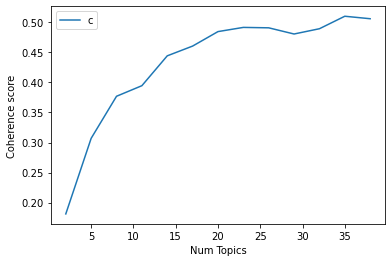

In [18]:
# Can take a long time to run.
limit=40; start=2; step=3;
model_list, coherence_values = loop_compute_coherence_values(id2word=id2word, corpus=corpus, texts=docs, mallet_path=mallet_path, start=start, limit=limit, step=step)

# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [19]:
coherence_values

[0.18111807889419942,
 0.3069857418245153,
 0.3770153075387129,
 0.3946363098394775,
 0.4443431511723297,
 0.4605954232303439,
 0.48470604721718813,
 0.4916932266272104,
 0.4909952406571094,
 0.4807049008608318,
 0.48947994444945814,
 0.5102746520337154,
 0.5061367752062007]

# Train LDA

In [32]:
datapath("model")

'C:\\Users\\olive\\anaconda3\\envs\\ugpn\\lib\\site-packages\\gensim\\test\\test_data\\model'

In [10]:
os.environ.update({'MALLET_HOME':r'C:/new_mallet/mallet-2.0.8/'})
mallet_path = 'C:\\new_mallet\\mallet-2.0.8\\bin\\mallet'

In [21]:
# Train model
#temp_file = datapath("topic_model_280322")
#ldamallet = gensim.models.wrappers.LdaMallet.load(temp_file)
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=23, id2word=id2word, random_seed=50)
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)

In [22]:
# Save the model
temp_file = datapath("topic_model_290322")
ldamallet.save(temp_file)

In [23]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
19     0.204070  0.336785       1        1  4.419006
17     0.109559  0.007884       2        1  4.399003
14     0.193997  0.318699       3        1  4.369862
12     0.104586  0.079593       4        1  4.369282
3      0.108431 -0.099069       5        1  4.365466
18     0.117056 -0.039680       6        1  4.363249
10     0.016487 -0.212723       7        1  4.362993
16     0.077735 -0.066748       8        1  4.362656
15     0.102666 -0.108636       9        1  4.361927
20     0.124977 -0.085855      10        1  4.360161
5      0.044918 -0.223303      11        1  4.353628
13    -0.156030  0.033315      12        1  4.351093
7      0.105589 -0.064210      13        1  4.342540
9     -0.069597  0.041325      14        1  4.341410
8      0.090788 -0.091289      15        1  4.339815
4     -0.176421 -0.051125      16        1  4.333398
2     -0.199272  0.129657      17        1  4.332336
21     0.116941 -0.047077      18        1  4.329737
6      0.016458  0.001324      19        1  4.320769
0     -0.211138 -0.079101      20        1  4.309992
22    -0.190717  0.045047      21        1  4.304308
11    -0.225562  0.088926      22        1  4.304300
1     -0.305519  0.086263      23        1  4.303069, topic_info=             Term           Freq          Total Category  logprob  loglift
1     coronavirus  463803.000000  463803.000000  Default  30.0000  30.0000
0           cases  208943.000000  208943.000000  Default  29.0000  29.0000
105      lockdown  145792.000000  145792.000000  Default  28.0000  28.0000
156       vaccine  117331.000000  117331.000000  Default  27.0000  27.0000
293      pandemic  175302.000000  175302.000000  Default  26.0000  26.0000
...           ...            ...            ...      ...      ...      ...
491       control    2177.411700    5168.703716  Topic23  -5.1197   2.2814
888       prepare    1833.492314    3250.144714  Topic23  -5.2916   2.5734
40      need_know    2085.848747    5583.685938  Topic23  -5.1627   2.1612
1630        north    1614.634522    2400.141460  Topic23  -5.4187   2.7494
231     emergency    1748.629089    6525.698694  Topic23  -5.3390   1.8289

[1253 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
621       7  0.000941        abroad
621      15  0.999145        abroad
1579      1  0.996870        active
1579      3  0.003277        active
2079      1  1.000046  active_cases
...     ...       ...           ...
833       7  0.037393  young_people
833      11  0.961535  young_people
833      14  0.001233  young_people
2125     14  0.000909   yyc_covidab
2125     17  0.998590   yyc_covidab

[2308 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[20, 18, 15, 13, 4, 19, 11, 17, 16, 21, 6, 14, 8, 10, 9, 5, 3, 22, 7, 1, 23, 12, 2])

### Selected model coherence

In [24]:
m_coherence = CoherenceModel(model=ldamallet, texts=docs, dictionary=dictionary, coherence='c_v')
m_coherence_general = m_coherence.get_coherence()
m_coherence_per_topic = m_coherence.get_coherence_per_topic()

In [25]:
pd.Series(np.round(np.array(m_coherence_per_topic) * 100,2))

0     35.88
1     44.75
2     42.59
3     39.55
4     54.56
5     52.17
6     35.88
7     51.21
8     45.32
9     50.20
10    53.96
11    35.31
12    57.63
13    40.25
14    61.12
15    54.37
16    42.50
17    51.30
18    69.75
19    73.74
20    48.83
21    45.78
22    44.25
dtype: float64

In [26]:
m_coherence_general

0.4916932266272104

### Topics prevalence

In [28]:
df_iter = ldamallet.load_document_topics()
df = []
for k in df_iter:
    df.append([i[1] for i in k])
df = pd.DataFrame(df, columns=[fr'topic_{k}' for k in range(23)])
df['topic'] = df.idxmax(axis=1)
df['num_topic'] = df.topic.apply(lambda x: int(x.replace('topic_','')))
df['tweet_id'] = news_tweets.tweet_id.values
df.to_csv('./../data/processed/news_tweets_topics_290322.csv', index=False)
df.num_topic.value_counts(normalize=True).sort_index() * 100

0     9.314335
1     8.384231
2     6.979610
3     6.243969
4     5.902769
5     5.620632
6     4.827767
7     4.966232
8     4.453483
9     4.265882
10    3.847608
11    3.436196
12    3.775557
13    2.630097
14    3.953356
15    2.582247
16    2.463449
17    2.226650
18    4.150025
19    3.474243
20    1.748885
21    2.705763
22    2.047013
Name: num_topic, dtype: float64

In [58]:
lda_topic_desc = pd.DataFrame([])
for topic in range(23):
    s = "_".join([dictionary[x] for x in [a[0] for a in model.get_topic_terms(topic,10)]])
    lda_topic_desc = lda_topic_desc.append({'topic_lda':topic, "lda_description":s}, ignore_index=True)
lda_topic_desc.topic_lda = lda_topic_desc.topic_lda.astype(int)

In [59]:
lda_topic_desc.to_csv('./../data/processed/lda_topic_description.csv', index=False)

### Topics keywords

In [ ]:
pprint(model.print_topics())

In [ ]:
df_words = pd.DataFrame([])
topic_words = pd.DataFrame(columns=['topic', 'words'])
for topic in range(20):
    tmp = pd.DataFrame(model.get_topic_terms(topic,35), columns=['wordid','imp'])
    tmp['topic'] = topic
    tmp['word'] = tmp.wordid.apply(lambda x: dictionary[x])
    df_words = pd.concat([df_words, tmp])
    topic_words.loc[len(topic_words)] = [topic, (list(tmp.word.values))]
(topic_words.words.values)

### Themes

In [ ]:
topic2theme = pd.DataFrame({
    'topic':[fr'topic_{k}' for k in range(20)], 
    'theme':[8,5,6,6,1,5,7,2,4,1,6,6,5,2,5,7,1,5,2,3]
})
df = df.merge(topic2theme, how='left')

In [ ]:
themes_keywords = []
for theme_id in range(1,9):
    theme = [int(t.replace('topic_', '')) for t in list(topic2theme[topic2theme.theme==theme_id].topic.values)]
    theme_words_tmp = pd.DataFrame()
    for topic in theme:
        tmp = pd.DataFrame(model.get_topic_terms(topic,40), columns=['wordid','imp'])
        theme_words_tmp = pd.concat([theme_words_tmp, tmp])
    theme_words_tmp = theme_words_tmp.sort_values('imp', ascending=False)
    theme_words_tmp['wordid'] = theme_words_tmp.wordid.apply(lambda x: dictionary[x])
    themes_keywords = themes_keywords + [list(theme_words_tmp.drop_duplicates('wordid').wordid.values[:40])]

In [ ]:
ch2 = CoherenceModel(topics=themes_keywords, texts=docs, dictionary=dictionary, coherence='c_v')

In [ ]:
cm = ch2.get_coherence()
ct = ch2.get_coherence_per_topic()

In [ ]:
ct

In [ ]:
cm

In [ ]:
df.theme.value_counts(normalize=True)

In [ ]:
theme_id = 8
theme = [int(t.replace('topic_', '')) for t in list(topic2theme[topic2theme.theme==theme_id].topic.values)]
np.array(list(dict.fromkeys(df_words[df_words.topic.isin(theme)].word.values)))

### Subthemes

In [ ]:
subthemes = [
    (1,11,['rise', 'increase', 'high', 'spike', 'jump', 'reach', 'double', 'climb', 'soar', 'record_high', 'death_toll_rise', 'peak', 'hit', 'high_daily', 'top', 'exceed', 'high_single_day', 'tally_rise']),
    (1,12,['low', 'drop', 'fall', 'dip', 'decrease']),
    (2,21,['worker', 'plan', 'work', 'support', 'free', 'job', 'employee', 'food', 'citizen', 'congress', 'poor', 'protect', 'people', 'vulnerable', 'household', 'essential', 'loan', 'small_business', 'lose_job', 'donation', 'employer', 'assistance', 'job_loss']),
    (2,22,['impact', 'business', 'government', 'economy', 'global', 'demand', 'market', 'company', 'industry', 'cut', 'aid', 'budget', 'sector', 'boost', 'bank', 'bill', 'stock', 'quarter', 'trade', 'law', 'growth', 'lawmaker', 'office', 'relief_bill', 'supreme_court', 'economic_recovery', 'debt', 'profit', 'relief_package', 'global_economy', 'stimulus_package', 'world_bank', 'relief_fund', 'organisation']),
    (4,41,['nurse_home', 'care_home']),
    (4,42,['mental_health']),
    (4,43,['jail', 'prison', 'cop', 'inmate']),
    (4,44,['family', 'couple', 'wife', 'mother', 'son', 'daughter', 'husband', 'father', 'mum', 'baby', 'dad']),
    (5,51,['health_official', 'health_minister', 'expert', 'task_force', 'public_health', 'dr_anthony_fauci', 'chief_medical_officer']),
    (5,52,['trump', 'pm', 'president', 'president_trump', 'minister', 'white_house', 'leader', 'pm_modi', 'governor', 'govt', 'president_donald_trump', 'donald_trump', 'administration', 'federal', 'biden', 'mp', 'joe_biden', 'trudeau', 'trump_administration', 'pm_narendra_modi', 'leadership', 'pres_trump', 'prime_minister_justin_trudeau', 'opposition', 'government']),
    (5,53,['election', 'poll', 'debate', 'voter']),
    (6,61,['lockdown', 'restriction', 'quarantine', 'police', 'rule', 'impose', 'protocol', 'quarantine_facility', 'mandatory', 'community_quarantine', 'stay_home_order', 'containment_zone', 'covidquarantine', 'quarantine_period']),
    (6,62,['travel', 'passenger', 'flight', 'airport', 'plan', 'airline', 'tourism', 'fly', 'traveller', 'travel_ban', 'trip', 'vaccine_passport']),
    (6,63,['protest', 'anti', 'break', 'arrest', 'fine', 'protester']),
    (6,64,['social_distance', 'mask', 'wear_mask', 'social_distance_measure']),
    (6,65,['christmas', 'holiday', 'easter']),
    (6,66,['ease', 'relax', 'restriction_ease', 'ease_restriction', 'slow_spread']),
    (7,71,['outbreak', 'fear', 'chinese', 'detect', 'epidemic', 'suspect', 'emerge', 'panic', 'epicentre', 'animal', 'origin', 'china', 'epicenter']),
    (7,72,['hospital', 'study', 'treatment', 'research', 'lab', 'expert', 'cure', 'researcher', 'scientist', 'ventilator', 'study_find', 'medicine', 'scientists', 'private_hospital', 'expert_warn', 'oxygen', 'researchers', 'intensive_care', 'study_show', 'hospitals', 'palliative']),
    (7,73,['variant', 'wave', 'strain', 'mutation']),
    (7,74,['doctor', 'medical', 'healthcare_worker', 'health_worker', 'doctors', 'health_care_worker'])
]

In [ ]:
for col in [fr'subtheme{subtheme[1]}' for subtheme in subthemes]:
    df[col] = False

In [ ]:
for k in range(1,9):
    subthemes_desc = [subtheme for subtheme in subthemes if subtheme[0]==k]
    if len(subthemes_desc)>0:
        indices = list(df[df.theme==k].index)
        topic_docs = [docs[i] for i in indices]
        for subtheme_desc in subthemes_desc:
            kw = subtheme_desc[2]
            t = [ind for k, ind in enumerate(indices) if any(i in topic_docs[k] for i in kw)]
            df.loc[t,fr'subtheme{subtheme_desc[1]}'] = True

In [ ]:
df[[fr'subtheme{subtheme[1]}' for subtheme in subthemes]].sum()

In [ ]:
df.to_parquet('./../data/processed/news_tweets_topics_0612.parquet', compression='gzip', index=False)

In [ ]:
df

# Trunk

In [ ]:
vis.sorted_terms(1, 0.64).Term.values

In [ ]:
model.get_term_topics(1)

In [ ]:
list(dictionary.values)

In [ ]:
with open("data_pp.pickle", "rb") as fp:   # Unpickling
    b = pickle.load(fp)

In [ ]:
themes_keywords2 = []
for theme in themes:
    theme_words_tmp = pd.DataFrame()
    for topic in theme:
        tmp = pd.DataFrame(model.get_topic_terms(topic,50), columns=['wordid','imp'])
        theme_words_tmp = pd.concat([theme_words_tmp, tmp])
    theme_words_tmp = theme_words_tmp.sort_values('imp', ascending=False)
    theme_words_tmp['wordid'] = theme_words_tmp.wordid.apply(lambda x: d[x])
    themes_keywords2 = themes_keywords2 + [list(theme_words_tmp.drop_duplicates('wordid').wordid.values[:50])]

In [ ]:
themes_keywords2[3]

In [ ]:
df_iter = ldamallet.load_document_topics()
df = []
for k in df_iter:
    df.append([i[1] for i in k])
df = pd.DataFrame(df, columns=[fr'topic_{k}' for k in range(20)])

In [ ]:
df['topic'] = df.idxmax(axis=1)
df

In [ ]:
df_iter = ldamallet.load_document_topics()
df = []
for k in df_iter:
    df.append([i[1] for i in k])
df = pd.DataFrame(df, columns=[fr'topic_{k}' for k in range(20)])
df['topic'] = df.idxmax(axis=1)

In [ ]:
topic2theme = pd.DataFrame({
    'topic':[fr'topic_{k}' for k in range(20)], 
    'theme':[7,3,2,1,2,1,2,5,7,6,6,6,5,7,5,8,1,4,4,6]
})

df = df.merge(topic2theme, how='left')

In [ ]:
for col in [fr'subtheme{subtheme[1]}' for subtheme in subthemes]:
    df[col] = False

In [ ]:
for k in range(1,9):
    subthemes_desc = [subtheme for subtheme in subthemes if subtheme[0]==k]
    if len(subthemes_desc)>0:
        indices = list(df[df.theme==k].index)
        topic_docs = [b[0][i] for i in indices]
        for subtheme_desc in subthemes_desc:
            kw = subtheme_desc[2]
            t = [ind for k, ind in enumerate(indices) if any(i in topic_docs[k] for i in kw)]
            df.loc[t,fr'subtheme{subtheme_desc[1]}'] = True

In [ ]:
tweets.tweetId.values

In [ ]:
df['tweetId'] = tweets.tweetId.values

In [ ]:
df[[fr'topic_{k}' for k in range(20)]].max(axis=1).max()

In [ ]:
df.shape[0]

In [ ]:
tweets[tweets.tweetId.isin(df[df.subtheme73].tweetId.values)].sample(25).content.values

In [ ]:
# Train model
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word, random_seed=50)
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)
temp_file = datapath("model")
ldamallet.save(temp_file)

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
vis

In [ ]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=docs, dictionary=dictionary, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

In [ ]:
# Train model
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
vis

In [ ]:
pprint(model.print_topics())
doc_lda = model[corpus]

In [ ]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=docs, dictionary=dictionary, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

In [ ]:
1

In [ ]:
ldamallet[corpus[10]]

In [ ]:
# Compute tweets topics
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=list(tweets.content))

# Format
df = df_topic_sents_keywords.reset_index()
df.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df.to_csv('tweets_topics2.csv')

# Show
df.head(5)

In [ ]:
df = pd.read_csv('tweets_topics2.csv')

In [ ]:
df[df.Topic_Perc_Contrib==0.05]

In [ ]:
indices = list(df_dominant_topic[df_dominant_topic.Dominant_Topic==2.0].Document_No)
topic_docs = [docs[i] for i in indices]

kw = ['low', 'fall', 'drop', 'decline']
t = [ind for k, ind in enumerate(indices) if any(i in topic_docs[k] for i in kw)]
len(t)

In [ ]:
(df.Dominant_Topic.value_counts() / df.shape[0]).sort_index()

In [ ]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(10)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
sent_topics_sorteddf_mallet.to_csv('relevant_topics2.csv', sep="|")

In [ ]:
sent_topics_sorteddf_mallet[sent_topics_sorteddf_mallet.Topic_Num==19.0].Text.values

In [ ]:
topic_desc = pd.read_csv('topic_desc.csv', sep=';')

In [ ]:
# required: tweets, df, docs
tweets['theme'] = np.nan
for topic in topic_desc.topic.unique():
    topic_themes = topic_desc[topic_desc.topic==topic]
    non_default = []
    for index, row in topic_themes[topic_themes.default=='F'].iterrows():
        kw = row.keywords.replace(' ', '').split(',')
        t = [k for k in df[df.Dominant_Topic==topic].Document_No.values if any(i in kw for i in docs[k])]
        tweets.loc[t, 'theme'] = row.theme_id
        non_default = non_default + t
    topic_tweets = [k for k in df[df.Dominant_Topic==topic].Document_No.values]
    topic_tweets = np.setdiff1d(topic_tweets,non_default)
    tweets.loc[topic_tweets, 'theme'] = topic_themes[topic_themes.default=='T'].theme_id.unique()[0]

In [ ]:
topic_themes.themes.unique()[0]

In [ ]:
topic = 11
topic_themes = topic_desc[topic_desc.topic==topic]
non_default = []

In [ ]:
topic_themes

In [ ]:
topic_desc

In [ ]:
topic = 10
topic_desc[topic_desc.topic==topic]

In [ ]:
topic = 1
topic_themes = topic_desc[topic_desc.topic==topic]
non_default = []
for index, row in topic_themes[topic_themes.default=='F'].iterrows():
    kw = row.keywords.replace(' ', '').split(',')
    t = [k for k in df[df.Dominant_Topic==topic].Document_No.values if any(i in kw for i in docs[k])]
    print(row.themes, len(t))

In [ ]:
topic = 1
for topic in topic_desc.topic.unique():
    topic_themes = topic_desc[topic_desc.topic==topic]
    non_default = []
    for index, row in topic_themes[topic_themes.default=='F'].iterrows():
        kw = row.keywords.replace(' ', '').split(',')
        t = [k for k in df[df.Dominant_Topic==topic].Document_No.values if any(i in kw for i in docs[k])]
        print(row.themes, len(t))

In [ ]:
tweets[tweets.theme=='Elections'].content[:10].values

In [ ]:
tweets[['tweetId', 'theme']].to_parquet('news_tweets_topics.parquet', compression='gzip', index=False)

In [ ]:
tweets.theme.value_counts() / tweets.shape[0]

In [ ]:
topic_desc.topic.unique()

In [ ]:
tweets.theme.isnull().sum()

In [ ]:
topic_desc.keywords[20]

In [ ]:
docs[92]

In [ ]:
tweets[tweets.theme=='People violating mobility restrictions or protesting against them'].sample(frac=1).head(10).content.values

In [ ]:
(tweets.theme.nunique())

In [ ]:
df[df.Dominant_Topic==3.0]